In [85]:
import pandas as pd
import glob
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [86]:
paths = glob.glob('data_finalized/**/paths.json', recursive=True)
properties = glob.glob('data_finalized/**/properties.json', recursive=True)

df_paths = pd.DataFrame([json.load(open(file)) for file in paths])
df_properties = pd.DataFrame([json.load(open(file)) for file in properties])

In [87]:
df = pd.merge(df_paths, df_properties, on='name')

df["path_count"] = df["paths"].apply(lambda x: len(x))
df["pairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if y["pairable"]]))
df["unpairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if not y["pairable"]]))
df["min_permanent"] = df["pathsdetailed"].apply(lambda x: min([y["permanent"] for y in x]))
df["max_permanent"] = df["pathsdetailed"].apply(lambda x: max([y["permanent"] for y in x]))

print(f'There are {df.query("pairable & min_permanent < 0").shape[0] / df.query("pairable").shape[0]:.1%} of pairable paths with negative permanents!')

There are 22.0% of pairable paths with negative permanents!


In [88]:
display(df.query("max_permanent == 9"))

,name,nodes,edges,pairable,determinant,permanent,pathsdetailed,paths,conductance,i,j,sites,path_count,pairablepath_count,unpairablepath_count,min_permanent,max_permanent
238,junction_24525851,18,21,True,-24,25,"[{'path': [6, 16, 5, 15], 'length': 4, 'pairab...","[{'length': 4, 'pairable': 0, 'unpairable': 1}...",0.778547,6,15,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",5,6,2,-1.0,9.0


[Text(0.5, 0, 'Number of pairable paths'), Text(0, 0.5, 'Conductance')]

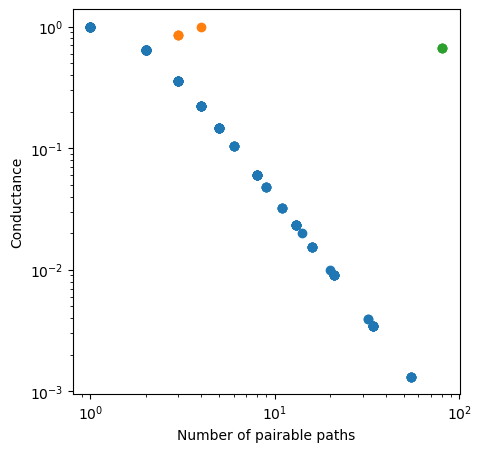

In [89]:
def f(x, a, b):
    # c = 1 - a
    # return a * np.exp(-b * x) + (1 - a)
    return a * x**(-b)

fig, ax = plt.subplots(figsize=(5, 5))
for max_permanent in [1, 4, 16, 64]:
    df_temp = df.query("max_permanent == @max_permanent & min_permanent >= 0")
    x = df_temp["pairablepath_count"].values
    y = df_temp["conductance"].values
    if len(df_temp) == 0:
        continue
    ax.scatter(x, y, label=f"max permanent={max_permanent}")
    if len(df_temp) > 1:
        popt, pcov = curve_fit(f, x, y)
        X = np.linspace(x.min(), x.max(), 100)
        Y = f(X, *popt)
        # ax.plot(X, Y, label=f"$y={popt[0]:.2f}\\exp(-{popt[1]:.2f}x)$")
    
#ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set(xlabel='Number of pairable paths', ylabel='Conductance')

In [90]:
def perm(M, max_complexity: int) -> float:
    n = M.shape[0]
    complexity = n * 2**n
    if complexity > max_complexity:
        return -1
    d = np.ones(n)
    j =  0
    s = 1
    f = np.arange(n)
    v = M.sum(axis=0)
    p = np.prod(v)
    while (j < n-1):
        v -= 2*d[j]*M[j]
        d[j] = -d[j]
        s = -s
        prod = np.prod(v)
        p += s*prod
        f[0] = 0
        f[j] = f[j+1]
        f[j+1] = j+1
        j = f[0]
    return p/2**(n-1)

In [91]:
M = np.array([
    [0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0]
]).astype(np.float64)

# 1) 1 == 2    3 == 4

# 1) 1 -- 2 -- 3 -- 4 -- 1
# 2) 1 == 2    3 == 4
# 3) 2 == 3    4 == 1
# 4) 4 -- 3 -- 2 -- 1 -- 4

# Permanent = number of ways to make loops, ordering conserved


perm(M, 10000)

4.0

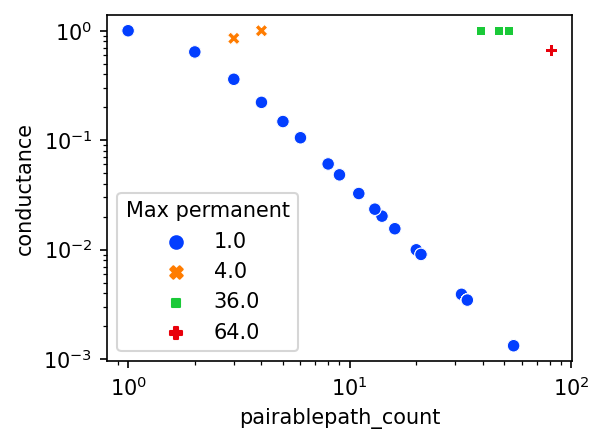

In [94]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.scatterplot(
    data=df.query("pairable & min_permanent >= 0"),
    x="pairablepath_count",
    y="conductance",
    hue="max_permanent",
    palette="bright",
    style="max_permanent",
    ax=ax,
)

# ax.set(xlabel='Number of pairable paths', ylabel='Conductance [$G_0$]')
ax.legend(title="Max permanent")
ax.set_xscale('log')
ax.set_yscale('log')

In [93]:
df

,name,nodes,edges,pairable,determinant,permanent,pathsdetailed,paths,conductance,i,j,sites,path_count,pairablepath_count,unpairablepath_count,min_permanent,max_permanent
0,junction_44101352,34,42,False,-729,-1,"[{'path': [34, 13, 30, 9, 29, 8, 25, 4, 24, 3,...","[{'length': 13, 'pairable': 0, 'unpairable': 1...",8.779150e-20,14,19,"[{'index': 0, 'x': 9.0, 'y': 0.0}, {'index': 1...",9,0,343,0.0,0.0
1,junction_83062356,30,37,True,0,-1,"[{'path': [5, 20, 2, 19, 1, 18], 'length': 6, ...","[{'length': 6, 'pairable': 0, 'unpairable': 3}...",2.214533e-01,5,16,"[{'index': 0, 'x': 4.5, 'y': 2.598076211353316...",10,4,84,-1.0,1.0
2,junction_56257305,12,13,False,1,1,"[{'path': [5, 14, 4, 13, 3], 'length': 5, 'pai...","[{'length': 5, 'pairable': 0, 'unpairable': 1}...",3.600000e-19,5,8,"[{'index': 0, 'x': 3.0, 'y': 0.0}, {'index': 1...",2,0,4,0.0,0.0
3,junction_54443898,30,37,True,-1,-1,"[{'path': [13, 27, 8, 22, 4, 21, 3, 18, 1, 17]...","[{'length': 10, 'pairable': 0, 'unpairable': 9...",3.251814e-02,13,16,"[{'index': 0, 'x': 7.5, 'y': 0.866025403784438...",9,11,147,0.0,1.0
4,junction_22304767,24,27,False,255,-1,"[{'path': [11, 23, 9, 22, 8, 20, 6, 19, 5, 17,...","[{'length': 15, 'pairable': 0, 'unpairable': 8...",3.906250e-23,11,12,"[{'index': 0, 'x': 10.5, 'y': 0.86602540378443...",2,0,16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,junction_84887692,30,37,True,-1,-1,"[{'path': [11, 25, 6, 24, 5, 23, 4, 22, 3, 21]...","[{'length': 10, 'pairable': 0, 'unpairable': 5...",1.051863e-01,11,20,"[{'index': 0, 'x': 6.0, 'y': 1.732050807568877...",10,6,159,0.0,1.0
462,junction_66702117,14,15,False,-15,16,"[{'path': [16, 6, 14, 4, 13, 3, 11, 1, 10], 'l...","[{'length': 9, 'pairable': 0, 'unpairable': 4}]",2.500000e-21,8,9,"[{'index': 0, 'x': 7.5, 'y': 0.866025403784438...",1,0,4,0.0,0.0
463,junction_60121584,27,32,True,0,-1,"[{'path': [14, 28, 11, 25, 8, 24, 7, 21, 4, 20...","[{'length': 13, 'pairable': 1, 'unpairable': 1...",2.339100e-02,14,17,"[{'index': 0, 'x': 9.0, 'y': 0.0}, {'index': 1...",7,13,51,0.0,1.0
464,junction_33516446,27,33,False,0,-1,"[{'path': [12, 25, 8, 20, 3, 16, 0], 'length':...","[{'length': 7, 'pairable': 0, 'unpairable': 1}...",5.017361e-39,12,14,"[{'index': 0, 'x': 4.5, 'y': 0.866025403784438...",8,0,80,0.0,0.0
